## Analyze and make the statistical comparison based on vorticity

Loaded 5011 embryos (unique dish_wells).
Analysis restricted to 289 time points (from 0.00h to 72.00h).
--- Analyzing: BLASTO vs NO BLASTO ---
Significant time points found: 117
  Details of significant time points:
    - At 0.50h: p_raw = 0.01751 | p_adj = 0.04363
    - At 0.75h: p_raw = 0.00280 | p_adj = 0.00749
    - At 1.00h: p_raw = 0.00107 | p_adj = 0.00306
    - At 1.25h: p_raw = 0.00510 | p_adj = 0.01352
    - At 1.50h: p_raw = 0.01436 | p_adj = 0.03616
    - At 15.75h: p_raw = 0.00964 | p_adj = 0.02509
    - At 16.00h: p_raw = 0.01439 | p_adj = 0.03616
    - At 20.25h: p_raw = 0.00128 | p_adj = 0.00360
    - At 20.50h: p_raw = 0.00004 | p_adj = 0.00013
    - At 20.75h: p_raw = 0.00001 | p_adj = 0.00002
    - At 21.00h: p_raw = 0.00000 | p_adj = 0.00000
    - At 21.25h: p_raw = 0.00000 | p_adj = 0.00000
    - At 21.50h: p_raw = 0.00000 | p_adj = 0.00000
    - At 21.75h: p_raw = 0.00000 | p_adj = 0.00000
    - At 22.00h: p_raw = 0.00000 | p_adj = 0.00000
    - At 22.25h: p_raw =

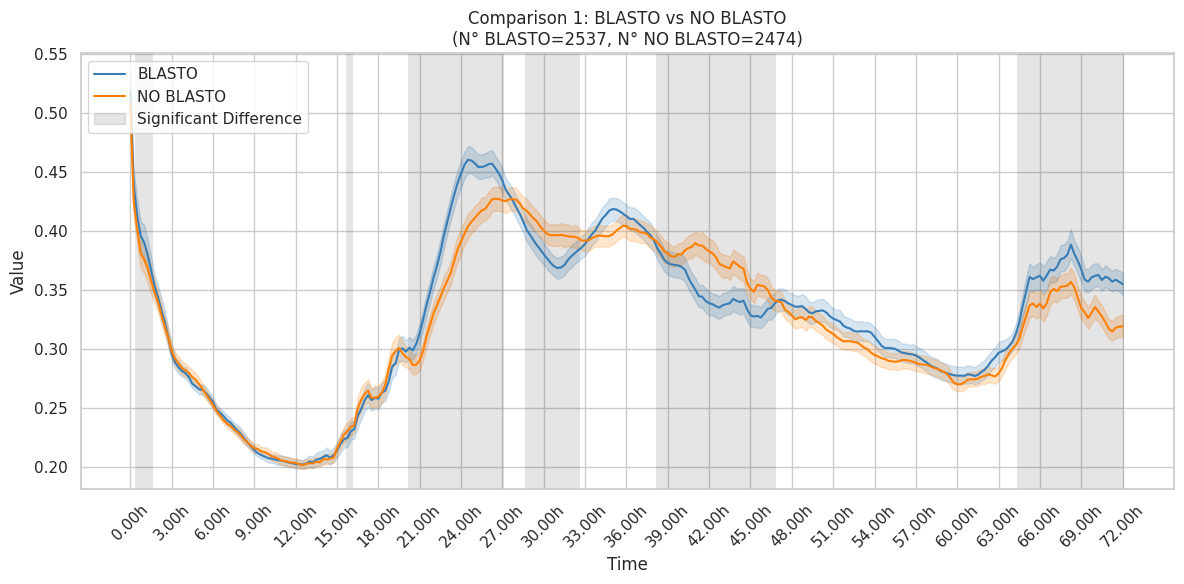

--- Analyzing: 2PN BLASTO vs 2PN NO_BLASTO ---
Significant time points found: 116
  Details of significant time points:
    - At 0.75h: p_raw = 0.01062 | p_adj = 0.02715
    - At 1.00h: p_raw = 0.00412 | p_adj = 0.01083
    - At 1.25h: p_raw = 0.01550 | p_adj = 0.03896
    - At 20.00h: p_raw = 0.01478 | p_adj = 0.03747
    - At 20.25h: p_raw = 0.00021 | p_adj = 0.00062
    - At 20.50h: p_raw = 0.00000 | p_adj = 0.00002
    - At 20.75h: p_raw = 0.00000 | p_adj = 0.00001
    - At 21.00h: p_raw = 0.00000 | p_adj = 0.00000
    - At 21.25h: p_raw = 0.00000 | p_adj = 0.00001
    - At 21.50h: p_raw = 0.00000 | p_adj = 0.00001
    - At 21.75h: p_raw = 0.00000 | p_adj = 0.00001
    - At 22.00h: p_raw = 0.00000 | p_adj = 0.00000
    - At 22.25h: p_raw = 0.00000 | p_adj = 0.00000
    - At 22.50h: p_raw = 0.00000 | p_adj = 0.00000
    - At 22.75h: p_raw = 0.00000 | p_adj = 0.00000
    - At 23.00h: p_raw = 0.00000 | p_adj = 0.00000
    - At 23.25h: p_raw = 0.00000 | p_adj = 0.00000
    - At 23.50h:

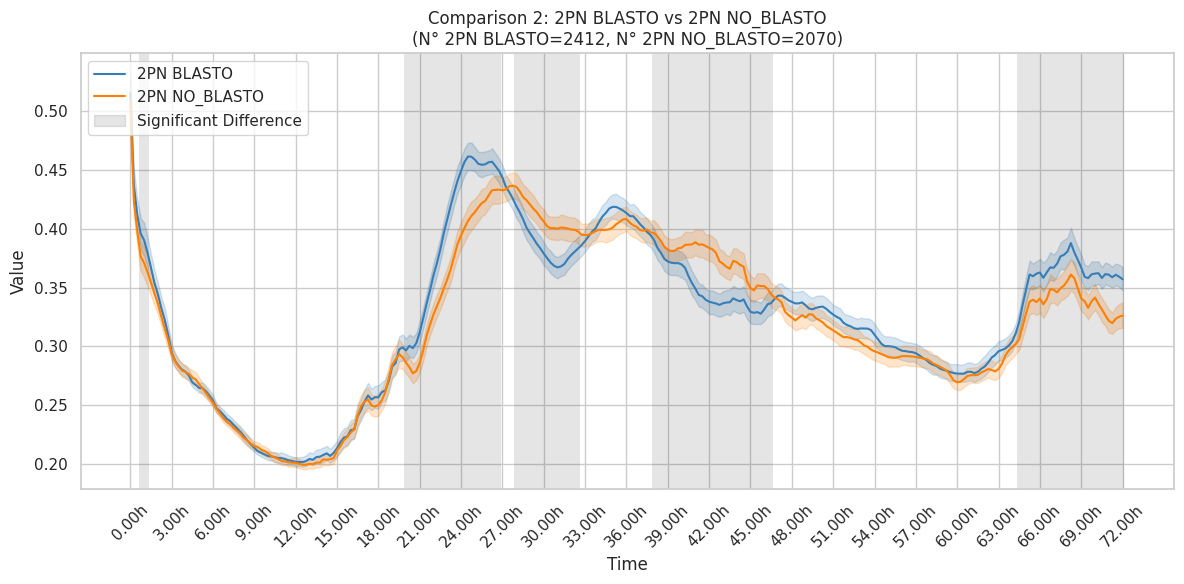

--- Analyzing: 2PN BLASTO vs 1.1PN BLASTO ---
--- Analyzing: 2PN BLASTO vs 1PN BLASTO ---
Significant time points found: 0


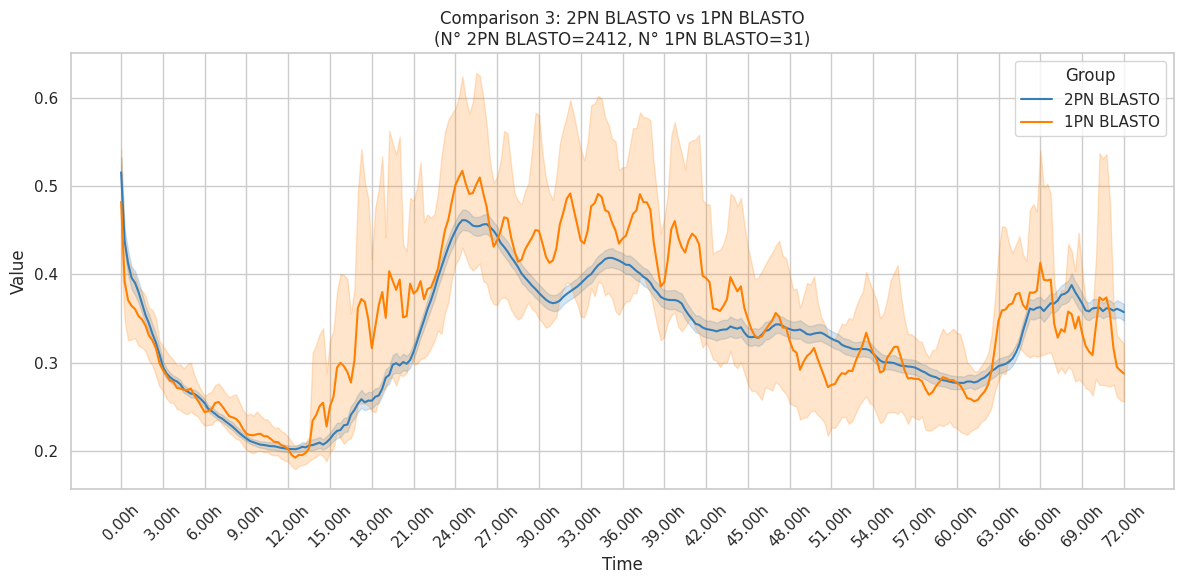

--- Analyzing: 2PN BLASTO vs 2.1PN BLASTO ---
Significant time points found: 0


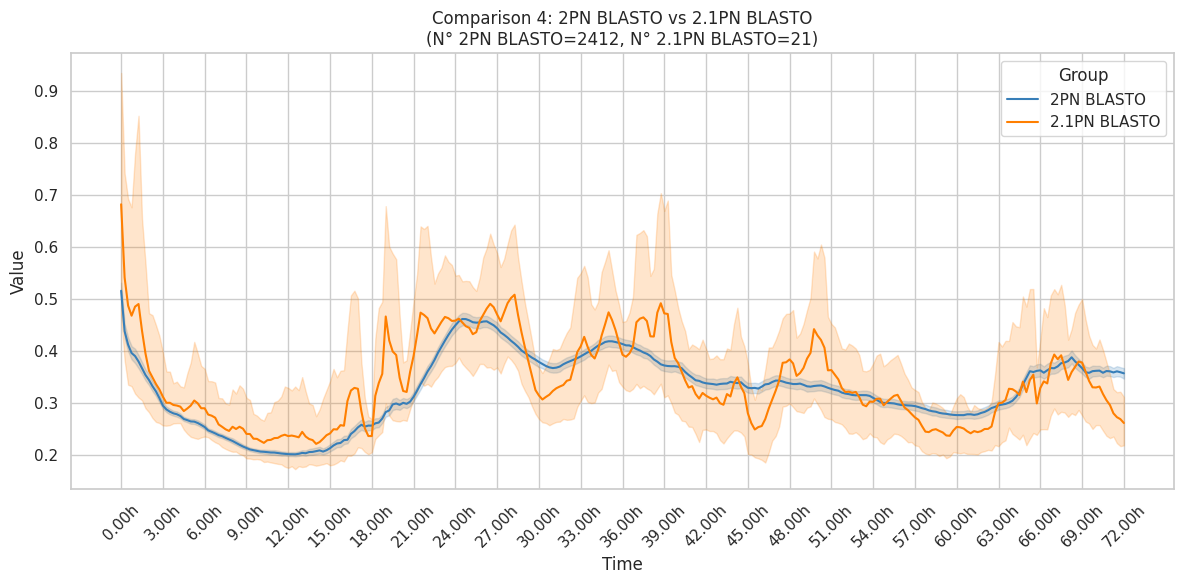

--- Analyzing: 2PN BLASTO vs 3PN BLASTO ---
Significant time points found: 0


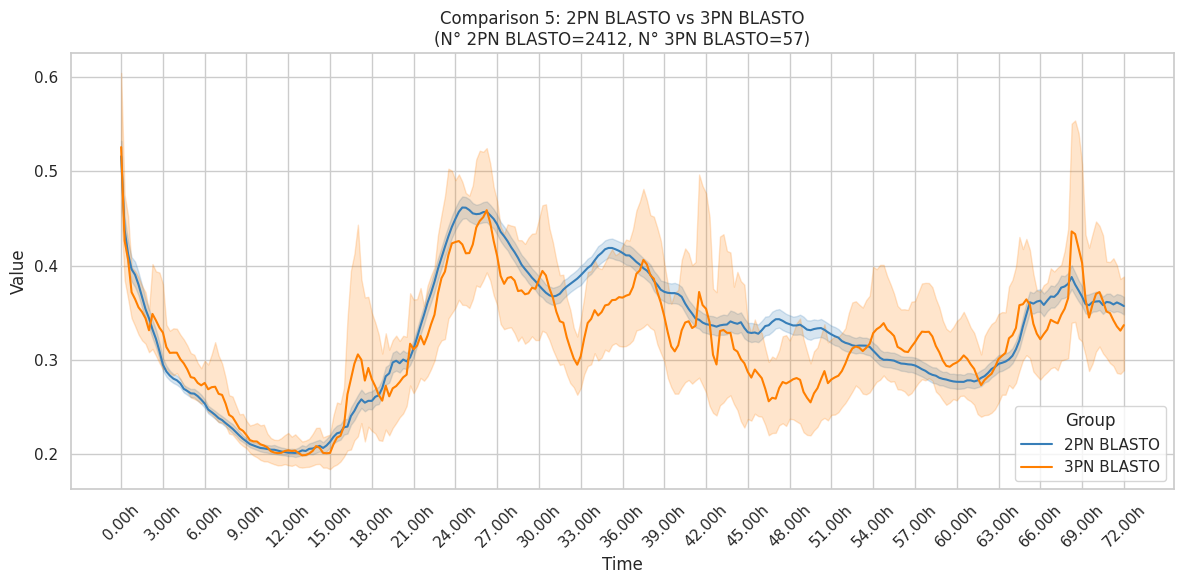

--- Analyzing: 2PN BLASTO vs >3PN BLASTO ---
Significant time points found: 0


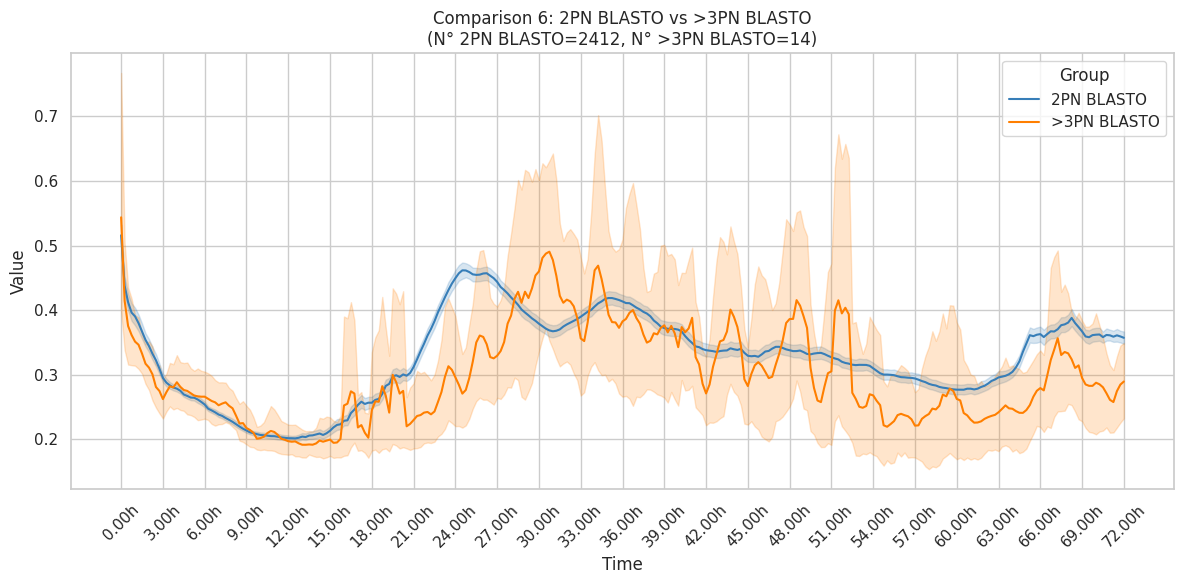

In [6]:
# %% [markdown]
# # Statistical Analysis of Time-Series: Embryo Metrics (0h - 24h)
# 
# **Goal:** Compare specific groups of embryos (identified by 'dish_well') to find where they differ.
# **Method:** Mann-Whitney U Test (Point-wise) + FDR Correction (Optional) + Mean/CI Visualization.

# %%
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Settings for nice plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %%
# ---------------- CONFIGURATION ----------------
CHOSEN_METRIC = 'sum_mean_mag'  # Options: 'sum_mean_mag' or 'vorticity'
if CHOSEN_METRIC == 'sum_mean_mag':
    INPUT_CSV = "/home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/Farneback/FinalDataset.csv"
elif CHOSEN_METRIC == 'vorticity':
    INPUT_CSV = "/home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/Farneback/FinalDataset_vorticity.csv"
else:
    raise ValueError("Invalid CHOSEN_METRIC. Choose 'sum_mean_mag' or 'vorticity'.")

MAX_TIME_HOUR = 72.0  # Cutoff time (included)

# --- STATISTICAL SETTINGS ---
# Set to True for rigorous publication standards (FDR Correction).
# Set to False to find more trends (Raw P-values + Consecutive Filter).
STRICT_CORRECTION = True 

# If STRICT_CORRECTION is False, a signal must last this many time steps to be considered real.
# 4 steps * 15 min = 1 hour duration. (Set to 2 as per your latest code)
MIN_CONSECUTIVE_STEPS = 2

# Destination folder for saving figures
SAVE_FIG = True
DESTINATION_FOLDER = f"/home/phd2/Scrivania/CorsoRepo/cellPIV/paper_figures/{CHOSEN_METRIC}_analysis/{MAX_TIME_HOUR}h"
os.makedirs(DESTINATION_FOLDER, exist_ok=True)

# Load Data
if CHOSEN_METRIC == 'sum_mean_mag':
    df = pd.read_csv(INPUT_CSV, sep=',')
elif CHOSEN_METRIC == 'vorticity':
    df = pd.read_csv(INPUT_CSV, sep=';')
else:
    raise ValueError("Invalid CHOSEN_METRIC. Choose 'sum_mean_mag' or 'vorticity'.")

# Convert 'BLASTO NY' to numeric (1/0)
df['BLASTO NY'] = pd.to_numeric(df['BLASTO NY'], errors='coerce')

# --- TIME COLUMN SELECTION (CUT AT MAX_TIME_HOUR) ---
all_time_cols = [c for c in df.columns if c.endswith('h')]

selected_time_cols = []
for col in all_time_cols:
    try:
        # Check if the numeric part is <= MAX_TIME_HOUR
        val = float(col.replace('h', ''))
        if val <= MAX_TIME_HOUR:
            selected_time_cols.append(col)
    except ValueError:
        continue 

time_cols = selected_time_cols
print(f"Loaded {len(df)} embryos (unique dish_wells).")
print(f"Analysis restricted to {len(time_cols)} time points (from {time_cols[0]} to {time_cols[-1]}).")

# %% [markdown]
# ## Helper Functions

# %%
def perform_pointwise_stats(group_a, group_b, time_cols, strict=True, min_steps=1, alpha=0.05):
    """
    Runs Mann-Whitney U test for every time point.
    
    If strict=True: Applies Benjamini-Hochberg FDR correction.
    If strict=False: Uses raw p-values but filters for consecutive consistency.
    """
    p_values = []
    valid_times = []
    
    for t in time_cols:
        a_vals = group_a[t].dropna()
        b_vals = group_b[t].dropna()
        
        # Need at least 2 samples per group to run a test
        if len(a_vals) < 2 or len(b_vals) < 2:
            p_values.append(np.nan)
            valid_times.append(t)
            continue
            
        # Mann-Whitney U Test
        stat, p = mannwhitneyu(a_vals, b_vals, alternative='two-sided')
        p_values.append(p)
        valid_times.append(t)
    
    res_df = pd.DataFrame({'time': valid_times, 'p_raw': p_values})
    
    if strict:
        # --- OPTION A: STRICT FDR CORRECTION ---
        mask = ~np.isnan(res_df['p_raw'])
        if mask.sum() > 0:
            reject, p_corrected, _, _ = multipletests(res_df.loc[mask, 'p_raw'], alpha=alpha, method='fdr_bh')
            res_df.loc[mask, 'p_adj'] = p_corrected
            res_df.loc[mask, 'significant'] = reject
        else:
            res_df['significant'] = False
    else:
        # --- OPTION B: RAW P-VALUES + CONSECUTIVE FILTER ---
        # 1. Identify raw significant points
        res_df['significant'] = res_df['p_raw'] < alpha
        
        # 2. Apply Consecutive Filter (remove isolated spikes)
        sig_array = res_df['significant'].fillna(False).values
        cleaned_sig = np.zeros_like(sig_array, dtype=bool)
        
        count = 0
        start_idx = 0
        for i, is_sig in enumerate(sig_array):
            if is_sig:
                if count == 0: start_idx = i
                count += 1
            else:
                if count >= min_steps:
                    cleaned_sig[start_idx:i] = True
                count = 0
        # Check last sequence
        if count >= min_steps:
            cleaned_sig[start_idx:] = True
            
        res_df['significant'] = cleaned_sig
        
    return res_df

def plot_comparison(df_a, df_b, stats_df, label_a, label_b, title):
    """
    Plots the Mean +/- 95% CI and highlights significant regions.
    """
    # 1. Reset index
    df_a_clean = df_a.reset_index(drop=True)
    df_b_clean = df_b.reset_index(drop=True)
    
    # 2. Melt to long format
    long_a = df_a_clean[time_cols].reset_index().melt(id_vars='index', var_name='Time', value_name='Value')
    long_a['Group'] = label_a
    
    long_b = df_b_clean[time_cols].reset_index().melt(id_vars='index', var_name='Time', value_name='Value')
    long_b['Group'] = label_b
    
    # 3. Concatenate (Safe Index)
    combined = pd.concat([long_a, long_b], ignore_index=True)
    
    # 4. Ensure Time is ordered categorical
    combined['Time'] = pd.Categorical(combined['Time'], categories=time_cols, ordered=True)
    
    # --- COLORBLIND PALETTE ---
    # Using a high-contrast Blue / Orange palette
    cb_palette = ["#377eb8", "#ff7f00"] # Blue, Orange (Safe for Deuteranopia/Protanopia)
    
    plt.figure()
    sns.lineplot(data=combined, x='Time', y='Value', hue='Group', errorbar=('ci', 95), palette=cb_palette)
    
    # Highlight significant regions
    sig_times = stats_df[stats_df['significant'] == True]['time'].tolist()
    
    if sig_times:
        time_map = {t: i for i, t in enumerate(time_cols)}
        for t in sig_times:
            if t in time_map:
                idx = time_map[t]
                # Light grey/green shading for significant regions
                plt.axvspan(idx - 0.5, idx + 0.5, color='black', alpha=0.1, linewidth=0)
            
        import matplotlib.patches as mpatches
        # Legend entry for the shaded region
        sig_patch = mpatches.Patch(color='black', alpha=0.1, label='Significant Difference')
        current_handles, current_labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles=current_handles + [sig_patch])
    
    plt.title(f"{title}\n(N° {label_a}={len(df_a)}, N° {label_b}={len(df_b)})")
    
    # Clean X-axis labels
    n_ticks = 25
    tick_idx = np.linspace(0, len(time_cols) - 1, n_ticks, dtype=int)

    plt.xticks(
        tick_idx,
        [time_cols[i] for i in tick_idx],
        rotation=45
    )

    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(f"{DESTINATION_FOLDER}/{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

def run_analysis(df_subset_a, df_subset_b, name_a, name_b, title_prefix):
    print(f"--- Analyzing: {name_a} vs {name_b} ---")
    if len(df_subset_a) < 3 or len(df_subset_b) < 3:
        print("WARNING: Sample size too small (<3). Skipping.")
        return
    
    # Pass the global configuration for strictness
    stats = perform_pointwise_stats(
        df_subset_a, 
        df_subset_b, 
        time_cols, 
        strict=STRICT_CORRECTION, 
        min_steps=MIN_CONSECUTIVE_STEPS,
        alpha=0.05
    )
    
    n_sig = stats['significant'].sum()
    print(f"Significant time points found: {n_sig}")
    
    # --- ADDED: Print p-values for significant points ---
    if n_sig > 0:
        print("  Details of significant time points:")
        sig_rows = stats[stats['significant'] == True]
        for _, row in sig_rows.iterrows():
            t = row['time']
            p_raw = row['p_raw']
            
            # Check if adjusted p-value exists (only in Strict mode)
            if 'p_adj' in row and not pd.isna(row['p_adj']):
                p_adj = row['p_adj']
                print(f"    - At {t}: p_raw = {p_raw:.5f} | p_adj = {p_adj:.5f}")
            else:
                print(f"    - At {t}: p = {p_raw:.5f}")
    
    plot_comparison(df_subset_a, df_subset_b, stats, name_a, name_b, f"{title_prefix}: {name_a} vs {name_b}")

# %% [markdown]
# ## Running the 7 Comparisons

# %%
# 1. BLASTO vs NO_BLASTO (All data)
group_blasto = df[df['BLASTO NY'] == 1]
group_noblasto = df[df['BLASTO NY'] == 0]
run_analysis(group_blasto, group_noblasto, "BLASTO", "NO BLASTO", "Comparison 1")

# %%
# Clean PN column
df['PN'] = df['PN'].astype(str).str.strip()

# Base group: 2PN BLASTO
g_2pn_blasto = df[(df['PN'] == '2PN') & (df['BLASTO NY'] == 1)]

# 2. 2PN BLASTO vs 2PN NO_BLASTO
g_2pn_noblasto = df[(df['PN'] == '2PN') & (df['BLASTO NY'] == 0)]
run_analysis(g_2pn_blasto, g_2pn_noblasto, "2PN BLASTO", "2PN NO_BLASTO", "Comparison 2")

# 3. 2PN BLASTO vs 1.1PN BLASTO
g_11pn_blasto = df[(df['PN'] == '1.1PN') & (df['BLASTO NY'] == 1)]
run_analysis(g_2pn_blasto, g_11pn_blasto, "2PN BLASTO", "1.1PN BLASTO", "Comparison 7")

# 4. 2PN BLASTO vs 1PN BLASTO
g_1pn_blasto = df[(df['PN'] == '1PN') & (df['BLASTO NY'] == 1)]
run_analysis(g_2pn_blasto, g_1pn_blasto, "2PN BLASTO", "1PN BLASTO", "Comparison 3")

# 5. 2PN BLASTO vs 2.1PN BLASTO
g_21pn_blasto = df[(df['PN'] == '2.1PN') & (df['BLASTO NY'] == 1)]
run_analysis(g_2pn_blasto, g_21pn_blasto, "2PN BLASTO", "2.1PN BLASTO", "Comparison 4")

# 6. 2PN BLASTO vs 3PN BLASTO
g_3pn_blasto = df[(df['PN'] == '3PN') & (df['BLASTO NY'] == 1)]
run_analysis(g_2pn_blasto, g_3pn_blasto, "2PN BLASTO", "3PN BLASTO", "Comparison 5")

# 7. 2PN BLASTO vs >3PN BLASTO
g_gt3pn_blasto = df[(df['PN'] == '>3PN') & (df['BLASTO NY'] == 1)]
run_analysis(g_2pn_blasto, g_gt3pn_blasto, "2PN BLASTO", ">3PN BLASTO", "Comparison 6")